# ACSE-8
## Coursework 2 - Training a classifier on CIFAR10

You task in this coursework is to implement, train and validate a classifier on the CIFAR10 dataset.  
You are free to use the code provided previously in the classroom exercises - but that code will need to be adapted to work on CIFAR10. 

Complete the following tasks:

1. Use ```torchvision.datasets.CIFAR10``` to load the CIFAR10 dataset. (1 point)
2. Plot 25 images of the training set together with their corresponding label names. (1 point)
3. Create a (90-10) training and validation split using ```sklearn.model_selection.StratifiedShuffleSplit```  (1 point)
4. Instantiate Datasets and Dataloader with correctly normalized CIFAR10, training, validation and test data. (1 point)
5. Modify LeNet5 from the morning excercise to be able to work with CIFAR10. (3 points)
6. Perform a line-search over the L2-Regularization parameter, use the ```weight_decay=value``` keyword argument in the ```torch.optim``` modules (5 points).
  - Other Hyperparameters:
    - Random Number Seed 42
    - Learning Rate = 1e-2
    - Momentum = 0.5
    - Batch Size = 64
    - Test Batch Size = 1000
    - Number of Epochs = 30
    - Optimizer = SGD
 - Values of weight_decay to use in line search: ```[0.0, 1e-3, 1e-4, 1e-5]```
7. Choose the best weight-decay value given the other hyperparameters and train on the full CIFAR10 training set (2 points).
8. Test your final model on the test set and store the model parameters in a ```.pth``` file (2 points).
9. Answer the following questions (1 point each):   
  **Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why?   **
  - Left-Right Flips
  - Random Rotations by up to 10 Degrees
  - Up-Down Flips
  - Shifting up-down, left-right by 5 pixels
  - Contrast Changes
  - Adding Gaussian Noise
  - Random Rotations by up to 90 Degrees

10. Bonus: Once you are certain you have achieved all points in the above excercise!
  - Use data-augmentation to train a CIFAR10 classifier using your best value of weight-decay and the other given hyperparameters. (4 points)
  - Use a different classifier (not LeNet-5) to beat your best classification accuracy with LeNet. (3 points)
  
 Describe your working as comments in a Jupyter Notebook together with your code implementation and provide the final Jupyter Notebook and your trained model weights in a github repository.
 
 Total Points: 23 (+7 Bonus Points)

# Import all packages, define seed function and apply GPU to train

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

!pip install pycm livelossplot
%pylab inline

from livelossplot import PlotLosses
from pycm import *

import matplotlib.pyplot as plt

     |████████████████████████████████| 61kB 3.1MB/s eta 0:00:011
     |████████████████████████████████| 542kB 12.0MB/s eta 0:00:01
Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

In [4]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


# 1. Use ```torchvision.datasets.CIFAR10``` to load the CIFAR10 dataset.

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data

Files already downloaded and verified


# 2. Plot 25 images of the training set together with their corresponding label names.

In [ ]:
target_name = []
for i in range(25):
    target_name.append(classes[trainset.targets[i]])

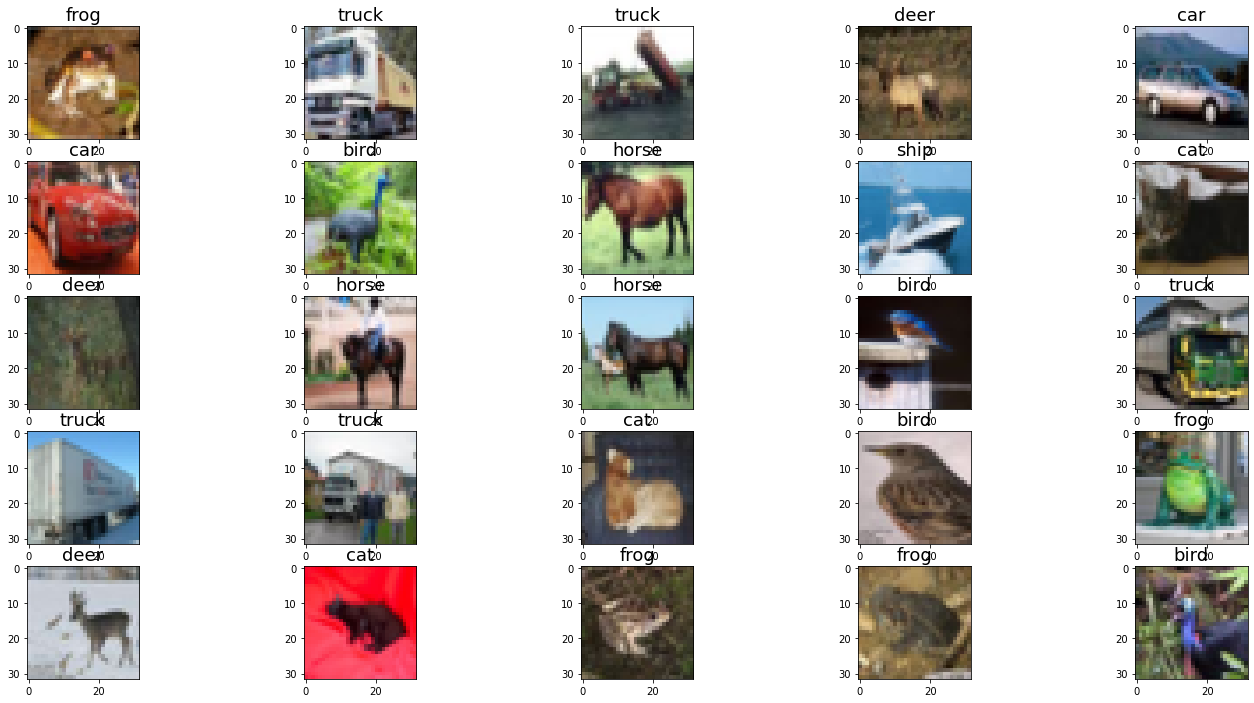

In [7]:
fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
for ax, op, name in zip(axarr.flatten(), trainset.data[:25], target_name):

    ax.imshow(op)
    ax.set_title(name, fontsize=18)
plt.show()

# 3. Create a (90-10) training and validation split using ```sklearn.model_selection.StratifiedShuffleSplit```

In [ ]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(trainset.data, trainset.targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

# 4. Instantiate Datasets and Dataloader with correctly normalized CIFAR10, training, validation and test data.

In [10]:
trainset.data.shape

(50000, 32, 32, 3)

* compute the mean and standard deviaion for each channel for normalization

In [11]:
c0 = np.transpose(trainset.data/255., (3,0,1,2))[0]
c1 = np.transpose(trainset.data/255., (3,0,1,2))[1]
c2 = np.transpose(trainset.data/255., (3,0,1,2))[2]
c0.shape

(50000, 32, 32)

In [12]:
c0mean = np.mean(c0)
c1mean = np.mean(c1)
c2mean = np.mean(c2)
c0mean, c1mean, c2mean

(0.49139967861519745, 0.4821584083946076, 0.44653091444546616)

In [13]:
c0std = np.sqrt(np.sum((c0 - c0mean)**2) / c0.size)
c1std = np.sqrt(np.sum((c1 - c0mean)**2) / c1.size)
c2std = np.sqrt(np.sum((c2 - c0mean)**2) / c2.size)
c0std, c1std, c2std

(0.2470322324632823, 0.24366043715074773, 0.2654079971252065)

* define the normalization function

In [ ]:
def apply_normalization(X):
    X /= 255.
    X[:,:,:,0] -= c0mean
    X[:,:,:,0] /= c0std
    
    X[:,:,:,1] -= c1mean
    X[:,:,:,1] /= c1std
    
    X[:,:,:,2] -= c2mean
    X[:,:,:,2] /= c2std
    
    return X

In [ ]:
train_data, train_labels = apply_normalization( trainset.data.astype(float)[indices[0]] ), np.array(trainset.targets)[indices[0]]
val_data, val_labels = apply_normalization( trainset.data.astype(float)[indices[1]] ), np.array(trainset.targets)[indices[1]]
test_data, test_labels =  apply_normalization(np.array(testset.data, dtype=float)), np.array(testset.targets)

In [16]:
train_data = torch.from_numpy( np.transpose(train_data, (0,3,1,2)) ).float()
val_data = torch.from_numpy( np.transpose(val_data, (0,3,1,2)) ).float()
test_data = torch.from_numpy( np.transpose(test_data, (0,3,1,2)) ).float()


train_labels = torch.from_numpy(train_labels)
val_labels = torch.from_numpy(val_labels)
test_labels = torch.from_numpy(test_labels)

train_data.shape, val_data.shape, test_data.shape

(torch.Size([45000, 3, 32, 32]),
 torch.Size([5000, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]))

In [17]:
len(train_labels), len(train_data)

(45000, 45000)

In [ ]:
train_set = TensorDataset(train_data, train_labels)
valset   = TensorDataset(val_data, val_labels)
testset = TensorDataset(test_data, test_labels)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=1000,
                                         shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                         shuffle=False)

# 5. Modify LeNet5 from the morning excercise to be able to work with CIFAR10.

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(16*6*6, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.act(self.c3(x))
        x = self.act(self.s4(x))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))  ##returns a "flattened" view of the 2d tensor as inputs for the fully connected layer
        x = self.act(self.c5(x))
        x = self.act(self.f6(x))
        return self.output(x)

net = LeNet5().to(device)

# 6. Perform a line-search over the L2-Regularization parameter, use the ```weight_decay=value``` keyword argument in the ```torch.optim``` modules

In [ ]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30
weight_decay = [0.0, 1e-3, 1e-4, 1e-5]

criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 32, 32))

        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 32, 32))

            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 32, 32))

            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [ ]:
def train_model(wd):
    set_seed(seed)
    model = LeNet5().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()
  
    liveloss = PlotLosses()
    for epoch in range(30):
        logs = {}
        
        print("epoch " + str(epoch) + ":")
        train_loss, train_accuracy = train(model, optimizer, criterion, trainloader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, valloader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
        
        print(train_loss, train_accuracy, validation_loss, validation_accuracy)
        
    return model, train_loss, train_accuracy, validation_loss, validation_accuracy

* train four models for different weight decay value

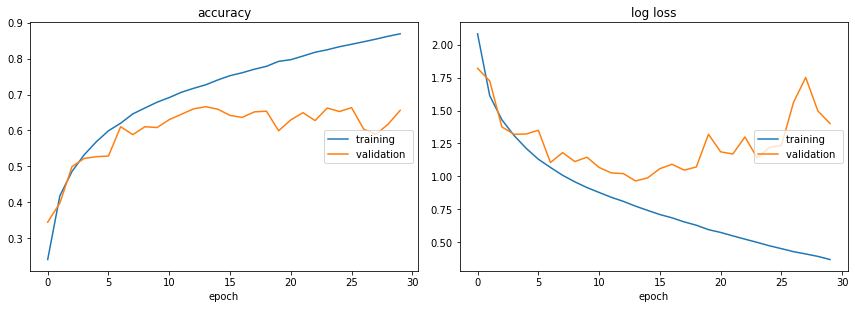

accuracy
	training         	 (min:    0.240, max:    0.869, cur:    0.869)
	validation       	 (min:    0.344, max:    0.666, cur:    0.656)
log loss
	training         	 (min:    0.368, max:    2.084, cur:    0.368)
	validation       	 (min:    0.965, max:    1.821, cur:    1.402)
tensor(0.3677, device='cuda:0', grad_fn=<DivBackward0>) 0.8691777777777778 tensor(1.4016, device='cuda:0') 0.6558
tensor(0.3677, device='cuda:0', grad_fn=<DivBackward0>) 0.8691777777777778 tensor(1.4016, device='cuda:0') 0.6558


In [24]:
model0, train_loss, train_accuracy, validation_loss, validation_accuracy = train_model(weight_decay[0])
print(train_loss, train_accuracy, validation_loss, validation_accuracy)
model_save_name = "LeNet5_classifier" + str(0) + ".pth"
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model0.state_dict(), path)

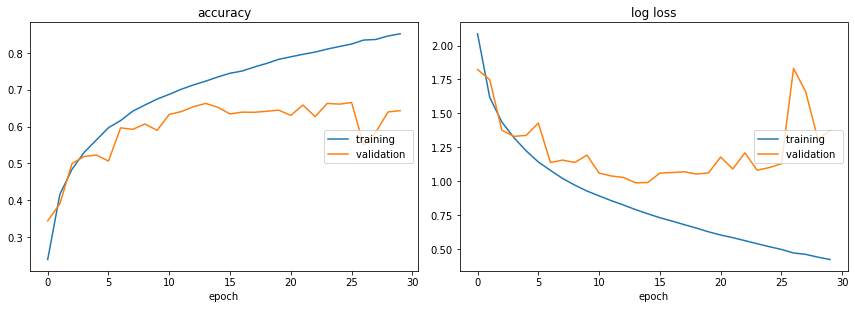

accuracy
	training         	 (min:    0.239, max:    0.869, cur:    0.852)
	validation       	 (min:    0.344, max:    0.666, cur:    0.643)
log loss
	training         	 (min:    0.368, max:    2.087, cur:    0.421)
	validation       	 (min:    0.965, max:    1.832, cur:    1.372)
tensor(0.4213, device='cuda:0', grad_fn=<DivBackward0>) 0.8521333333333333 tensor(1.3725, device='cuda:0') 0.6432
tensor(0.4213, device='cuda:0', grad_fn=<DivBackward0>) 0.8521333333333333 tensor(1.3725, device='cuda:0') 0.6432


In [25]:
model1, train_loss, train_accuracy, validation_loss, validation_accuracy = train_model(weight_decay[1])
print(train_loss, train_accuracy, validation_loss, validation_accuracy)
model_save_name = "LeNet5_classifier" + str(1) + ".pth"
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model1.state_dict(), path)

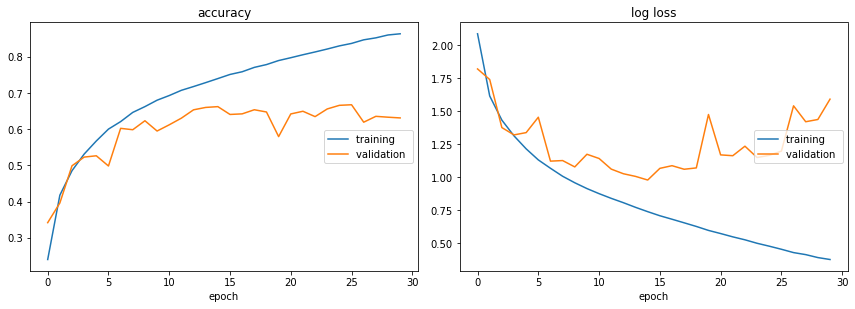

accuracy
	training         	 (min:    0.239, max:    0.869, cur:    0.863)
	validation       	 (min:    0.342, max:    0.667, cur:    0.631)
log loss
	training         	 (min:    0.368, max:    2.087, cur:    0.378)
	validation       	 (min:    0.965, max:    1.832, cur:    1.590)
tensor(0.3780, device='cuda:0', grad_fn=<DivBackward0>) 0.8634666666666667 tensor(1.5904, device='cuda:0') 0.631
tensor(0.3780, device='cuda:0', grad_fn=<DivBackward0>) 0.8634666666666667 tensor(1.5904, device='cuda:0') 0.631


In [26]:
model2, train_loss, train_accuracy, validation_loss, validation_accuracy = train_model(weight_decay[2])
print(train_loss, train_accuracy, validation_loss, validation_accuracy)
model_save_name = "LeNet5_classifier" + str(2) + ".pth"
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model2.state_dict(), path)

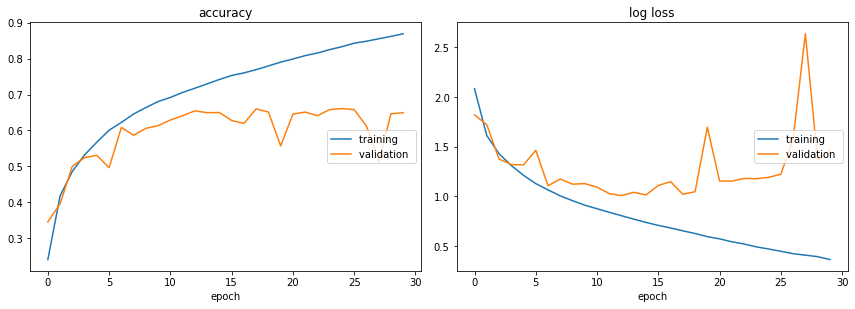

accuracy
	training         	 (min:    0.239, max:    0.869, cur:    0.869)
	validation       	 (min:    0.342, max:    0.667, cur:    0.649)
log loss
	training         	 (min:    0.366, max:    2.087, cur:    0.366)
	validation       	 (min:    0.965, max:    2.637, cur:    1.459)
tensor(0.3656, device='cuda:0', grad_fn=<DivBackward0>) 0.8692444444444445 tensor(1.4587, device='cuda:0') 0.6492
tensor(0.3656, device='cuda:0', grad_fn=<DivBackward0>) 0.8692444444444445 tensor(1.4587, device='cuda:0') 0.6492


In [27]:
model3, train_loss, train_accuracy, validation_loss, validation_accuracy = train_model(weight_decay[3])
print(train_loss, train_accuracy, validation_loss, validation_accuracy)
model_save_name = "LeNet5_classifier" + str(3) + ".pth"
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model3.state_dict(), path)

# 7. Choose the best weight-decay value given the other hyperparameters and train on the full CIFAR10 training set

In [ ]:
net0 = LeNet5().to(device)
net1 = LeNet5().to(device)
net2 = LeNet5().to(device)
net3 = LeNet5().to(device)

In [ ]:
basepath = "/content/gdrive/My Drive/models/LeNet5_classifier"
latterpath = ".pth"
path0 = basepath + "0" + latterpath
path1 = basepath + "1" + latterpath
path2 = basepath + "2" + latterpath
path3 = basepath + "3" + latterpath

In [30]:
net0.load_state_dict(torch.load(path0, map_location='cpu'))
net1.load_state_dict(torch.load(path1, map_location='cpu'))
net2.load_state_dict(torch.load(path2, map_location='cpu'))
net3.load_state_dict(torch.load(path3, map_location='cpu'))

<All keys matched successfully>

In [ ]:
valloss0, _ = validate(net0, criterion, valloader)
valloss1, _ = validate(net1, criterion, valloader)
valloss2, _ = validate(net2, criterion, valloader)
valloss3, _ = validate(net3, criterion, valloader)

In [32]:
np.argmin((valloss0, valloss1, valloss2, valloss3))

1

* so the best weight decay value is 1e-3

# 8. Test your final model on the test set and store the model parameters in a ```.pth``` file

In [59]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((c0mean, c1mean, c2mean), (c0std, c1std, c2std))
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

full_train_data, full_train_labels = apply_normalization( full_trainset.data.astype(float) ), np.array(trainset.targets)

full_train_data = torch.from_numpy( np.transpose(full_train_data, (0,3,1,2)) ).float()

full_train_labels = torch.from_numpy(full_train_labels)

full_train_set = TensorDataset(full_train_data, full_train_labels)

fullset_train_loader = torch.utils.data.DataLoader(full_train_set, batch_size=64, shuffle=True)

Files already downloaded and verified


In [ ]:
def fullset_train_model():
    set_seed(seed)
    model = LeNet5().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay[1])
    criterion = nn.CrossEntropyLoss()
  
    liveloss = PlotLosses()
    for epoch in range(30):
        logs = {}
        
        print("epoch " + str(epoch) + ":")
        train_loss, train_accuracy = train(model, optimizer, criterion, fullset_train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, testloader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
         
        print(train_loss, train_accuracy, validation_loss, validation_accuracy)
        
    return model, train_loss, train_accuracy, validation_loss, validation_accuracy

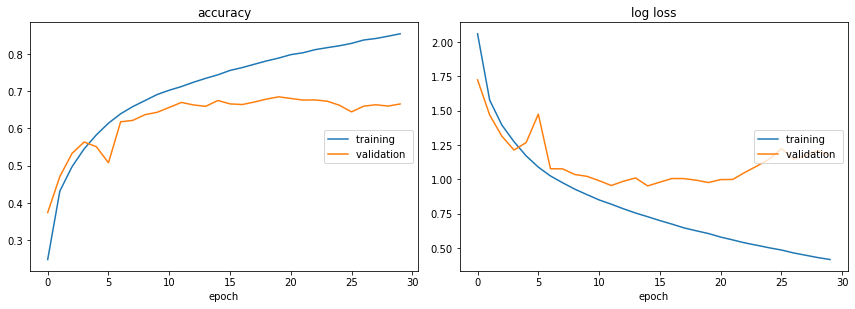

accuracy
	training         	 (min:    0.119, max:    0.869, cur:    0.854)
	validation       	 (min:    0.172, max:    0.685, cur:    0.666)
log loss
	training         	 (min:    0.366, max:    2.294, cur:    0.415)
	validation       	 (min:    0.951, max:    5.773, cur:    1.174)
tensor(0.4147, device='cuda:0', grad_fn=<DivBackward0>) 0.85406 tensor(1.1738, device='cuda:0') 0.6656
tensor(0.4147, device='cuda:0', grad_fn=<DivBackward0>) 0.85406 tensor(1.1738, device='cuda:0') 0.6656


In [61]:
fullset_model, train_loss, train_accuracy, validation_loss, validation_accuracy = fullset_train_model()
print(train_loss, train_accuracy, validation_loss, validation_accuracy)
model_save_name = "fullset_model_LeNet5_classifier.pth"
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(fullset_model.state_dict(), path)

In [62]:
fullset_model_load = LeNet5().to(device)
fullset_model_load.load_state_dict(torch.load("/content/gdrive/My Drive/models/fullset_model_LeNet5_classifier.pth"))

<All keys matched successfully>

In [63]:
y_preds, y_gt = evaluate(fullset_model_load, testloader)
(y_preds == y_gt).sum() / len(y_preds)

0.6656

In [64]:
test_loss, test_accuracy = validate(fullset_model_load, criterion, testloader)
test_loss, test_accuracy

(tensor(1.1738, device='cuda:0'), 0.6656)

# 9. Answer the following questions
**Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why?   **
  - Left-Right Flips
  - Random Rotations by up to 10 Degrees
  - Up-Down Flips
  - Shifting up-down, left-right by 5 pixels
  - Contrast Changes
  - Adding Gaussian Noise
  - Random Rotations by up to 90 Degrees

## Left-Right Flips

**YES**

Because the relative position of different features is not changed too much, so the LeNet is still able to recognise the more abstract features to classify images

## Random Rotations by up to 10 Degrees

**YES**

the same reason as the first answer

## Up-Down Flips

**NO**

According to common sense, we know the ships and sea cannot be on the "sky". So it will add difficulty for Neural Network to recognise it. And we can find the accuracy for LeNet5 in this dataset is only about 64%, so I do not think the LeNet is complex enough to recognise the complex feature

## Shifting up-down, left-right by 5 pixels

**YES**

shifting will not change relative position of the different features. And we can find the boundaries are normally some unimportant data, so LeNet can still reconise abstract features and classify images

## Contrast Changes

**YES**

Changing contrast will multiply the whole image with number, so it is just like normalization and it will not influence significantly the performance of the classifier

## Adding Gaussian Noise

**YES**

the noise can make the LeNet to be more robust to classifier some images that are difficult to classify.

## Random Rotations by up to 90 Degrees

**NO**

Just like the Up-Down Flips, the ships and sea cannot be on the left center or right center in real world, so it will still be difficult for simple LeNet to learn features.

# 10.1 Data-augmentation

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        sample = sample.float()/255.
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [46]:
augmentation_train_transform = Compose([
    ToPILImage(),
    RandomRotation(10),
    ToTensor(),
    transforms.Normalize((c0mean, c1mean, c2mean), (c0std, c1std, c2std))
])

aug_trainset = CustomImageTensorDataset(torch.from_numpy( np.transpose(trainset.data[indices[0]], (0,3,1,2)) ), np.array(trainset.targets)[indices[0]], transform=augmentation_train_transform)
aug_train_loader = torch.utils.data.DataLoader(aug_trainset, batch_size=64,
                                          shuffle=True)

aug_trainset.data.shape

torch.Size([45000, 3, 32, 32])

* plot some pictures to validate the result of transformation

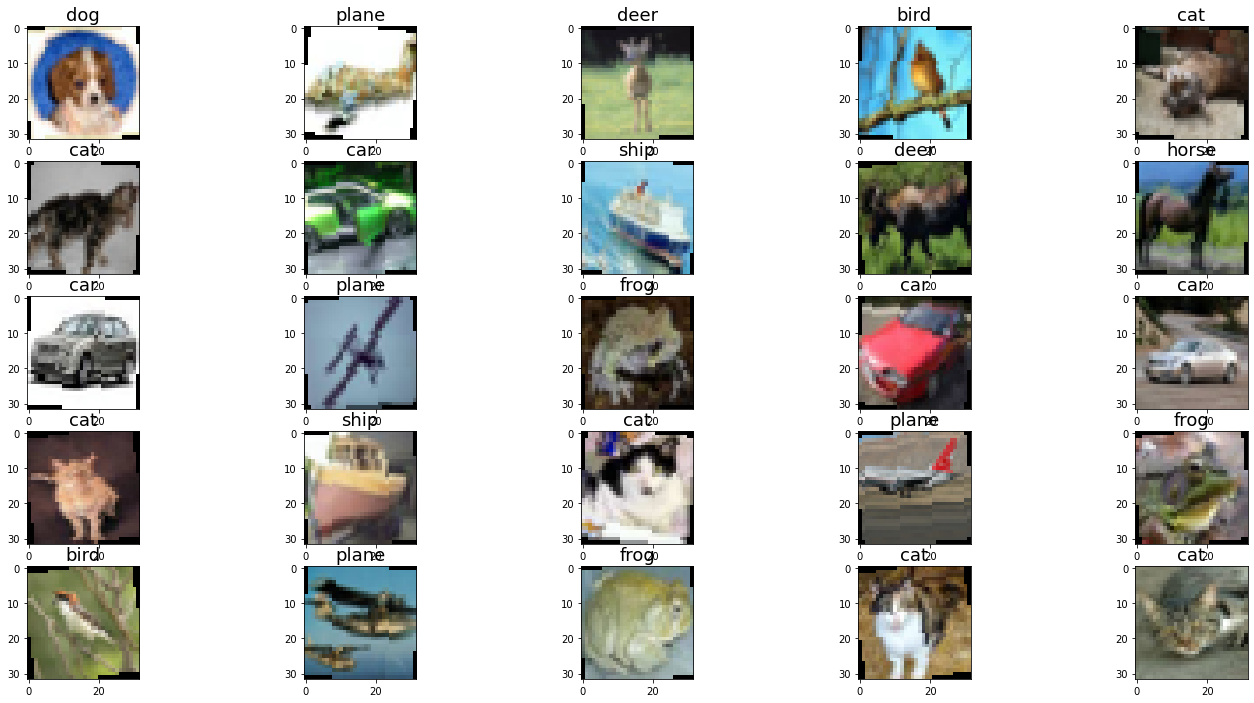

In [47]:
aug_train_data,aug_target = iter(aug_train_loader).next()

aug_target_name = []
for i in range(25):
    aug_target_name.append(classes[aug_target[i]])

fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
for ax, X, name in zip(axarr.flatten(), aug_train_data[:25], aug_target_name[:25]):
    
    X = X.numpy()
    
    X[0] = X[0] * c0std
    X[0] = X[0] + c0mean
    
    X[1] = X[1] * c1std
    X[1] = X[1] + c1mean
    
    X[2] = X[2] * c2std
    X[2] = X[2] + c2mean
    
    X = X * 255.
    X = X.astype(int)
    
    ax.imshow(np.transpose(X ,(1,2,0)))
    ax.set_title(name, fontsize=18)
plt.show()

* define new function to train augmentation dataset

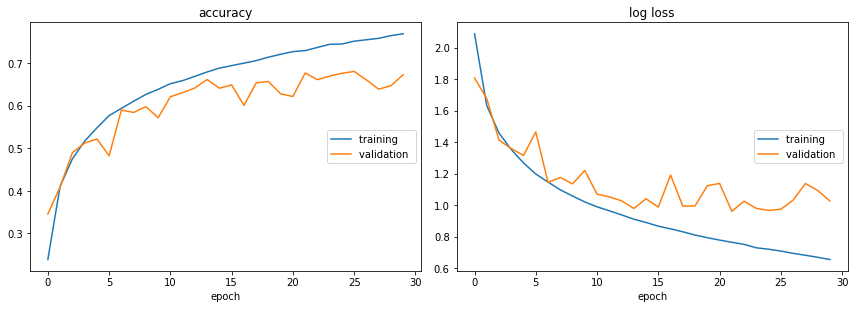

accuracy
	training         	 (min:    0.119, max:    0.869, cur:    0.769)
	validation       	 (min:    0.172, max:    0.680, cur:    0.673)
log loss
	training         	 (min:    0.366, max:    2.294, cur:    0.656)
	validation       	 (min:    0.961, max:    5.773, cur:    1.028)


In [48]:
def train_model_augmented(momentum=0.5):
    set_seed(seed)
    model = LeNet5().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    liveloss = PlotLosses()
    for epoch in range(30):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, aug_train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, valloader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
      
    return model

pre_aug_model = train_model_augmented()

In [ ]:
model_save_name = "aug_pre_LeNet5_classifier.pth"
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(pre_aug_model.state_dict(), path)

In [50]:
pre_aug = LeNet5().to(device)
pre_aug.load_state_dict(torch.load("/content/gdrive/My Drive/models/aug_pre_LeNet5_classifier.pth", map_location='cpu'))

<All keys matched successfully>

In [53]:
validate(pre_aug, criterion,testloader)

(tensor(1.0242, device='cuda:0'), 0.667)

# 10.2 Change to Vgg16

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.c1 = nn.Conv2d(3, 64, kernel_size=(12, 12), stride=(4, 4), padding=(2, 2))
        self.s2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.c3 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.s4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.c5 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.c6 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.c7 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.s8 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.c9 = nn.Linear(1016064, 10000)
        self.f10 = nn.Linear(10000, 1000)
        self.output = nn.Linear(1000, 10)
        self.act = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.act(self.c3(x))
        x = self.act(self.s4(x))
        x = self.act(self.c5(x))
        x = self.act(self.c6(x))
        x = self.act(self.c7(x))
        x = self.act(self.s8(x))
        
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))  ##returns a "flattened" view of the 2d tensor as inputs for the fully connected layer
        x = self.act(self.c9(x))
        x = self.act(self.f10(x))
        return self.output(x)

In [ ]:
class Vgg16(nn.Module):
    def __init__(self, num_classes=10):
        super(Vgg16, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #2
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #3
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #4
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #5
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #6
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #7
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #8
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #9
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #10
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #11
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #12
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #13
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.AvgPool2d(kernel_size=1,stride=1),
            )
        self.classifier = nn.Sequential(
            #14
            nn.Linear(512,4096),
            nn.ReLU(True),
            nn.Dropout(),
            #15
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            #16
            nn.Linear(4096,num_classes),
            )

 
    def forward(self, x):
        out = self.features(x) 
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [ ]:
def Vgg_train_model():
    set_seed(seed)
    model = Vgg16().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay[1])
    criterion = nn.CrossEntropyLoss()
  
    liveloss = PlotLosses()
    for epoch in range(5):
        logs = {}
        
        print("epoch " + str(epoch) + ":")
        train_loss, train_accuracy = train(model, optimizer, criterion, trainloader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, valloader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
        
        print(train_loss, train_accuracy, validation_loss, validation_accuracy)
        
    return model, train_loss, train_accuracy, validation_loss, validation_accuracy

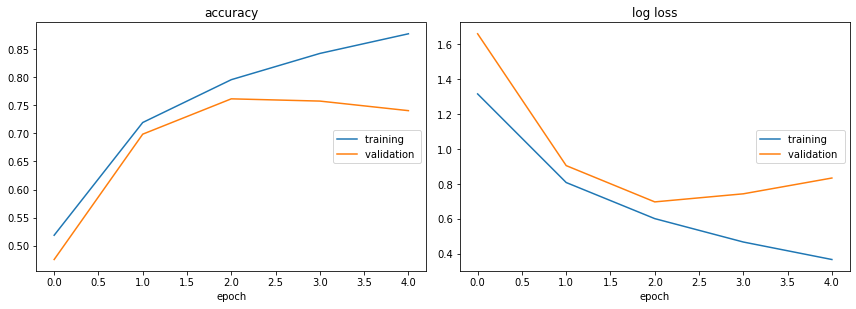

accuracy
	training         	 (min:    0.119, max:    0.877, cur:    0.877)
	validation       	 (min:    0.172, max:    0.761, cur:    0.740)
log loss
	training         	 (min:    0.366, max:    2.294, cur:    0.366)
	validation       	 (min:    0.696, max:    5.773, cur:    0.833)
tensor(0.3663, device='cuda:0', grad_fn=<DivBackward0>) 0.8768222222222222 tensor(0.8332, device='cuda:0') 0.7402
tensor(0.3663, device='cuda:0', grad_fn=<DivBackward0>) 0.8768222222222222 tensor(0.8332, device='cuda:0') 0.7402


In [68]:
vgg16_model, train_loss, train_accuracy, validation_loss, validation_accuracy = Vgg_train_model()
print(train_loss, train_accuracy, validation_loss, validation_accuracy)
model_save_name = "Vgg16_classifier.pth"
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(vgg16_model.state_dict(), path)

In [69]:
y_preds, y_real = evaluate(vgg16_model, testloader)
(y_preds == y_real).sum() / len(y_preds)

0.746

In [70]:
validate(vgg16_model, criterion, testloader)

(tensor(0.8492, device='cuda:0'), 0.746)

* we can find that vgg16 with only 5 epochs can beat the LeNet5 with 30 epochs, so vgg16 performs better than LeNet5